In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
torch.backends.cudnn.enabled = False

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.dropout = nn.Dropout(0.5)
        self.lin1 = nn.Linear(320,50)
        self.lin2 = nn.Linear(50,10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
def get_dataset(batch_size):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_trainset = datasets.MNIST('../data/train', train=True, download=True, transform=transform)
    mnist_testset = datasets.MNIST('../data/test', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(list(zip(mnist_trainset.data, mnist_trainset.targets)), batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(list(zip(mnist_testset.data, mnist_testset.targets)), batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader, test_loader

In [6]:
def train(lr, batch_size, gamma):
        
    model = Model()
    epochs = 1
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    device = torch.device("cuda:0")
    model.to(device)
    
    train_loader, test_loader = get_dataset(batch_size)

    train_loss = []
    test_loss = []
    for epoch in range(epochs):

        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device).float(), targets.to(device)
            images = images.reshape(batch_size,1,28,28)
            optimizer.zero_grad()
            output = model(images)
            loss = F.nll_loss(output, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        model.eval()
        temp = []
        for images, targets in test_loader:
            images, targets = images.to(device).float(), targets.to(device)
            images = images.reshape(batch_size,1,28,28)
            output = model(images)
            loss = F.nll_loss(output, targets)
            temp.append(loss.item())
        test_loss.append(np.mean(temp))
    return train_loss, test_loss

In [7]:
lr_vals = [0.001, 0.0001, 0.00001]
batch_size_vals = [256, 512]
gamma_vals = [1, 0.99, 0.75]

train_curves = []
test_curves = []
hypers = []

for lr in lr_vals:
    for batch_size in batch_size_vals:
        for gamma in gamma_vals:
            print("training on {}, {}, {}...".format(lr, batch_size, gamma))
            train_curve, test_curve = train(lr, batch_size, gamma)
            train_curves.append(train_curve)
            test_curves.append(test_curve)
            hypers.append((lr, batch_size, gamma))

training on 0.001, 256, 1...
training on 0.001, 256, 0.99...
training on 0.001, 256, 0.75...
training on 0.001, 512, 1...
training on 0.001, 512, 0.99...
training on 0.001, 512, 0.75...
training on 0.0001, 256, 1...
training on 0.0001, 256, 0.99...
training on 0.0001, 256, 0.75...
training on 0.0001, 512, 1...
training on 0.0001, 512, 0.99...
training on 0.0001, 512, 0.75...
training on 1e-05, 256, 1...
training on 1e-05, 256, 0.99...
training on 1e-05, 256, 0.75...
training on 1e-05, 512, 1...
training on 1e-05, 512, 0.99...
training on 1e-05, 512, 0.75...


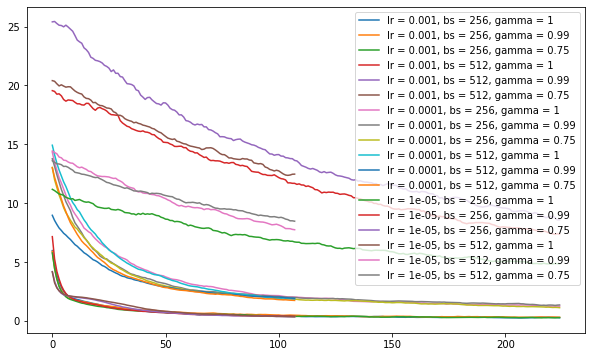

In [8]:
plt.figure(figsize=(10,6))
for train_loss, test_loss, hyper in zip(train_curves, test_curves, hypers):
    plt.plot(np.convolve(train_loss, np.ones(10)/10, mode='valid'), label='lr = {}, bs = {}, gamma = {}'.format(hyper[0], hyper[1], hyper[2]))
plt.legend()
plt.show()